In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("movies.csv")

# Preview first few rows
df.head()

# Check for missing values
df.info()

# See genre distribution
df['Genre'].value_counts()

# Sample plots and genres
df[['Plot', 'Genre']].sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


,Plot,Genre
9915,"In 1840s Madrid, Spain, Don Diego de la Vega i...",comedy
25895,Ranjit Rai (Sadashiv Amrapurkar) and Harbans L...,"romance, comedy"
20373,A team of reporters come up against censorship...,drama
19310,"Recently diagnosed with a terminal disease, Br...",western
30984,"The film starts with two ten-year-old boys, Na...",unknown


In [2]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download required NLTK data
nltk.download()

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return " ".join(words)

# Apply cleaning to Plot column
df['Clean_Plot'] = df['Plot'].astype(str).apply(clean_text)
df[['Plot', 'Clean_Plot']].head()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


,Plot,Clean_Plot
0,"A bartender is working at a saloon, serving dr...",bartender working saloon serving drinks custom...
1,"The moon, painted with a smiling face hangs ov...",moon painted smiling face hangs park night you...
2,"The film, just over a minute long, is composed...",film minute long composed two shots first girl...
3,Lasting just 61 seconds and consisting of two ...,lasting seconds consisting two shots first sho...
4,The earliest known adaptation of the classic f...,earliest known adaptation classic fairytale fi...


Genre
unknown                                                 6083
drama                                                   5964
comedy                                                  4379
horror                                                  1167
action                                                  1098
                                                        ... 
action, adventure, superhero, comedy, sci-fi               1
drama, fantasy, horror, romance                            1
sport film                                                 1
adventure, drama film                                      1
olga khokhlova, sergey krapiventsev, oleg sukachenko       1
Name: count, Length: 2265, dtype: int64


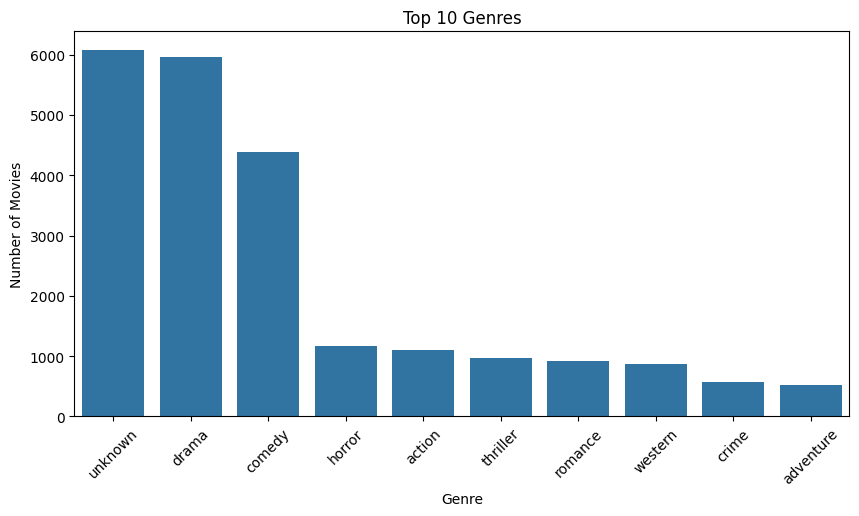

Remaining genres:  ['unknown' 'comedy' 'drama' 'horror' 'action']


In [3]:
# Count genres
genre_counts = df['Genre'].value_counts()
print(genre_counts)

# Plot genre distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.barplot(x = genre_counts.index[:10], y = genre_counts.values[:10])
plt.title("Top 10 Genres")
plt.ylabel("Number of Movies")
plt.xticks(rotation = 45)
plt.show()

# Simplify labels
top_genres = genre_counts.index[:5]
df = df[df['Genre'].isin(top_genres)]
print("Remaining genres: ", df['Genre'].unique())

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer with basic params
vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (1, 2))

# Fit & transform the cleaned plots
X = vectorizer.fit_transform(df['Clean_Plot'])

print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (18691, 5000)


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode genres as integers
le = LabelEncoder()
y = le.fit_transform(df['Genre'])

# Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 14952
Testing samples: 3739


In [11]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
model = LogisticRegression(class_weight = 'balanced', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [12]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred = model.predict(X_test)

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.60


In [13]:
from sklearn.metrics import classification_report

# Decode labels back to original genres
target_names = le.inverse_transform(sorted(set(y_test)))

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      action       0.30      0.51      0.38       220
      comedy       0.61      0.69      0.65       876
       drama       0.64      0.58      0.61      1193
      horror       0.60      0.85      0.70       233
     unknown       0.67      0.54      0.60      1217

    accuracy                           0.60      3739
   macro avg       0.57      0.63      0.59      3739
weighted avg       0.62      0.60      0.61      3739



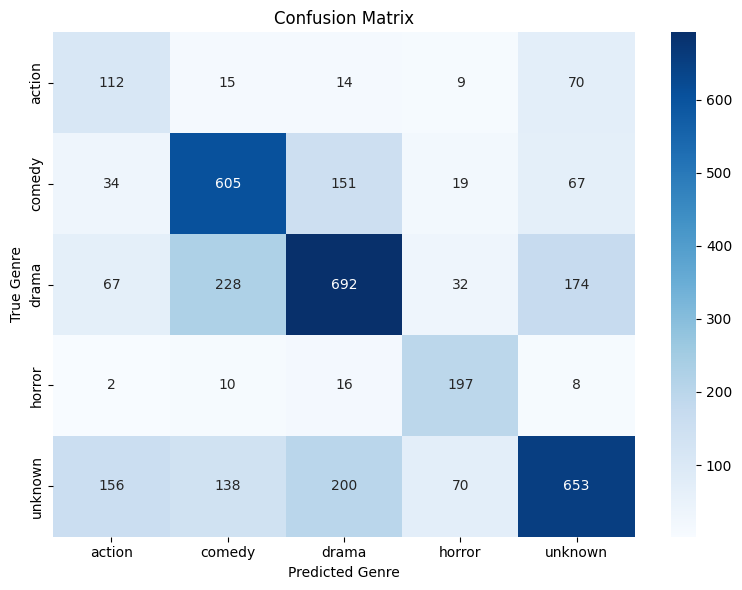

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.inverse_transform(sorted(set(y_test))),
            yticklabels=le.inverse_transform(sorted(set(y_test))))
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [15]:
import joblib

# Save the trained logistic regression model
joblib.dump(model, 'genre_classifier_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Save the LabelEncoder used for genres
joblib.dump(le, 'label_encoder.pkl')

print("Model, vectorizer, and label encoder saved successfully.")

Model, vectorizer, and label encoder saved successfully.


In [16]:
# Reload model and vectorizer
model_loaded = joblib.load('genre_classifier_model.pkl')
vectorizer_loaded = joblib.load('tfidf_vectorizer.pkl')
le_loaded = joblib.load('label_encoder.pkl')

# Example prediction
sample_plot = ["An orphan boy discovers he is a wizard and attends a magical school."]
X_sample = vectorizer_loaded.transform(sample_plot)
predicted_genre = le_loaded.inverse_transform(model_loaded.predict(X_sample))

print("Predicted Genre:", predicted_genre[0])

Predicted Genre: drama
